In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
	#t
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	#t+1
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [ ]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
#load the dataset
dataframe = pd.read_csv('AAPL.csv') 
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
1,2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2,2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
3,2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
4,2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [ ]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


In [ ]:
dataframe['Date'].min()

'2016-11-14'

In [ ]:
dataframe['Date'].max()

'2020-11-13'

#Data preprocessing

In [ ]:
#1. Kiểm tra NaN --> không có NaN
dataframe.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
#2. Loại bỏ những dòng bị trùng (all-columns, nếu có):
dataframe = dataframe.drop_duplicates()
dataframe = dataframe.reset_index(drop=True) 

In [ ]:
dataset = dataframe[['Open']]
dataset = dataset.values.astype('float32')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
#split into train and test sets
train_size = int(len(dataset) * 0.85) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size: len(dataset), :]

In [ ]:
print(train_size)
print(test_size) 

856
152


In [ ]:
#reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
print(trainX[:5])
print(trainY[:5])

[[0.00256878]
 [0.        ]
 [0.00029293]
 [0.00730075]
 [0.00709796]]
[0.         0.00029293 0.00730075 0.00709796 0.00799929]


In [ ]:
print(testX[:5])
print(testY[:5])

[[0.36445168]
 [0.390793  ]
 [0.39620093]
 [0.40742245]
 [0.40136108]]
[0.390793   0.39620093 0.40742245 0.40136108 0.3861737 ]


In [ ]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=50,
                    batch_size=128,
                    callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 2s 81ms/step - loss: 0.0362 - val_loss: 0.3655
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0290 - val_loss: 0.3291
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.2949
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0180 - val_loss: 0.2627
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.2340
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.2081
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.1856
Epoch 8/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.1674
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.1529
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.1424
Epoch 11/50
7/7 [=====================

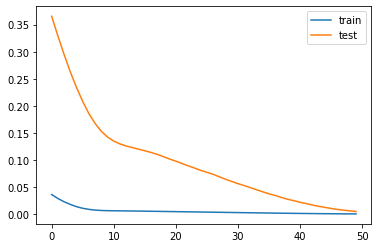

In [ ]:
#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Nhận xét: sau 50 lần lặp loss của train và test đã gần như bằng nhau.

In [ ]:
#make prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainY[0][:5]

array([26.64249951, 26.67499903, 27.45249934, 27.43000031, 27.53000022])

In [ ]:
trainPredict[:5]

array([[31.72082 ],
       [31.51104 ],
       [31.534948],
       [32.107925],
       [32.091316]], dtype=float32)

In [ ]:
#calculate the root mean squared error
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f RMSE' %(train_rmse))
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f RMSE' %(test_rmse))

Train RMSE: 2.40 RMSE
Test RMSE: 7.84 RMSE


In [ ]:
train_mae = mean_absolute_error(trainY[0], trainPredict[:, 0])
print('Train MAE: %.2f MAE' % (train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:, 0])
print('Test MAE: %.2f MAE' % (test_mae))

Train MAE: 1.88 MAE
Test MAE: 7.18 MAE


Nhận xét: mean(Open) ~ 55, test MAE ~ 7.18 --> model có thể dự đoán với độ sai khác với mean là 7.18/ 55 ~ 13%, có thể sử dụng được để dự đoán

In [ ]:
#shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan 
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
#shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan 
testPredictPlot[len(trainPredict) + (look_back*2) + 1:len(dataset)-1, :] = testPredict

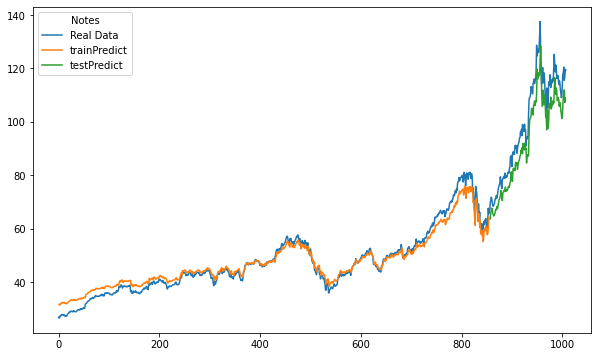

In [ ]:
#plot baseline and predictions
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title='Notes')
plt.show()

Nhận xét: phần train bám khá sát với real data, phần test so với real data hơi bị lệch nhưng không bị overfitting quá mức, có thể chấp nhận được với sự sai khác so với mean là 13%